# Color Quantization with Unsupervised Machine Learning (Focus on the label object instead of the background)

Name: Anthony Kevin Oktavius

Recommendation:

If we tend to choose the dataset which pixels focused on the background instead of the object label itself, the result will be more biased to the dominant object, which is the background itself.

So, to mitigate this, instead of finding the most dominant colors, we now try to find the least one.

Library Import

In [1]:
import numpy as np
import zipfile
import gc
import pickle
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import pickle
import collections

# import pytorch_lightning as pl
import imutils
import zipfile

from wordcloud import WordCloud
from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from google.colab.patches import cv2_imshow

Get the dataset

In [3]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d imsparsh/flowers-dataset
! unzip -qq ./flowers-dataset.zip -d ./Dataset

 99% 203M/205M [00:02<00:00, 151MB/s]
100% 205M/205M [00:02<00:00, 96.7MB/s]


## Data Modelling

Added PyTorch transform module to perform some preprocessing steps.

In [43]:
flowers_image_transform = transforms.Compose([
  transforms.Resize((320, 400)),
  transforms.ToTensor(),
])

Use Pytorch to build an imagefolder class to help preparing the dataset.

In [45]:
flowers_image_folder = torchvision.datasets.ImageFolder(
    "/content/Dataset/train",
    transform = flowers_image_transform
)

print(f"Number of classes: {len(flowers_image_folder.classes)}")
print(flowers_image_folder[1][1])
flowers_image_folder[1][0].shape

Number of classes: 5
0


torch.Size([3, 320, 400])

In [47]:
class FlowerPerClassDataset(Dataset):
  def __init__(self, image_folder):
    super(FlowerPerClassDataset, self).__init__()
    self.image_folder = image_folder
    self.number_of_classes = len(self.image_folder.classes)

  def __filter_classes_from_image_folder__(self, class_index):
    matched_images = list(
        filter(lambda item: item[1] == class_index, self.image_folder)
    )
    return matched_images

  def __getitem__(self, class_index):
    return self.__filter_classes_from_image_folder__(class_index)

  def __len__(self):
    return self.number_of_classes

flower_per_class_dataset = FlowerPerClassDataset(
    image_folder = flowers_image_folder
)

print(flower_per_class_dataset[0][0])
print(flower_per_class_dataset[0][1])

(tensor([[[0.8353, 0.8235, 0.8078,  ..., 0.0392, 0.0353, 0.0353],
         [0.8196, 0.8549, 0.8392,  ..., 0.0431, 0.0314, 0.0275],
         [0.8549, 0.8510, 0.8667,  ..., 0.0431, 0.0353, 0.0235],
         ...,
         [0.8667, 0.8588, 0.8667,  ..., 0.7059, 0.6941, 0.6588],
         [0.8902, 0.8980, 0.8980,  ..., 0.7176, 0.7059, 0.6627],
         [0.8941, 0.8980, 0.8863,  ..., 0.7255, 0.7098, 0.6510]],

        [[0.8549, 0.8235, 0.8235,  ..., 0.0314, 0.0275, 0.0353],
         [0.8510, 0.8627, 0.8549,  ..., 0.0353, 0.0275, 0.0275],
         [0.8784, 0.8588, 0.8706,  ..., 0.0392, 0.0353, 0.0275],
         ...,
         [0.8941, 0.8706, 0.8824,  ..., 0.6784, 0.6706, 0.6314],
         [0.8980, 0.8980, 0.8980,  ..., 0.6667, 0.6588, 0.6235],
         [0.9059, 0.9176, 0.9098,  ..., 0.6706, 0.6549, 0.5922]],

        [[0.8863, 0.8549, 0.8510,  ..., 0.0510, 0.0471, 0.0510],
         [0.8784, 0.8902, 0.8824,  ..., 0.0549, 0.0471, 0.0431],
         [0.9098, 0.8863, 0.9020,  ..., 0.0588, 0.0549, 0

Iterate the images one by one, then performing color quantization with various unsupervised machine learning.

In [66]:
rgb_occurence_dict = defaultdict(int)

def flatten_color_images_to_2d_array(images):
  return images.reshape(images.shape[1] * images.shape[2], 3)

def denormalize_image(images):
  RGB_COLOR_RANGE = 255
  images = images * RGB_COLOR_RANGE
  return images

def get_n_dominant_colors_from_images(images, k_means, rgb_occurence_dict):
  images_reshaped = flatten_color_images_to_2d_array(images)
  images_reshaped = denormalize_image(images_reshaped)
  images_reshaped = images_reshaped.astype(int)
  k_means.fit(images_reshaped)

  cluster_centers = k_means.cluster_centers_.astype(int)

  # Determine the most frequent label (color) among all of the pixels given.
  # pixel_labels = k_means.labels_
  # count_pixel_labels = np.unique(pixel_labels, return_counts = True)
  # label_with_most_pixels = np.argmax(count_pixel_labels[1])

  # color_key = cluster_centers[label_with_most_pixels].astype(str)
  # color_key = " ".join(color_key)
  # rgb_occurence_dict[color_key] += 1

  for cluster_center in cluster_centers:
    color_key = cluster_center.astype(str)
    color_key = " ".join(color_key)
    rgb_occurence_dict[color_key] += 1

  return rgb_occurence_dict

MAX_COLORS = 10
class_index = 0
for image_per_class, _ in flower_per_class_dataset[class_index]:
  image_np = image_per_class.numpy()
  k_means = KMeans(n_clusters = MAX_COLORS, n_init = 'auto')
  rgb_occurence_dict = get_n_dominant_colors_from_images(
      image_np,
      k_means,
      rgb_occurence_dict,
  )

In [71]:
print(rgb_occurence_dict)

defaultdict(<class 'int'>, {'44 132 209': 1, '181 181 180': 2, '132 131 131': 1, '7 7 7': 20, '206 207 206': 6, '155 155 155': 6, '76 71 72': 1, '108 107 106': 1, '232 233 232': 3, '27 26 27': 6, '232 234 233': 1, '101 101 102': 3, '20 19 20': 9, '164 164 162': 2, '74 73 74': 3, '47 46 47': 8, '178 129 82': 1, '129 129 129': 8, '93 141 186': 1, '197 200 197': 2, '190 192 190': 2, '50 49 50': 13, '143 144 142': 1, '13 13 13': 9, '119 119 117': 1, '70 69 69': 2, '56 99 141': 1, '32 32 32': 5, '166 168 166': 1, '101 95 88': 1, '41 41 41': 10, '124 130 127': 1, '79 93 105': 1, '21 21 21': 9, '65 66 65': 2, '128 91 56': 1, '155 157 154': 1, '34 34 34': 8, '28 28 28': 6, '51 51 51': 10, '251 252 251': 2, '155 145 133': 1, '177 179 177': 1, '90 91 92': 1, '24 23 24': 8, '116 115 112': 1, '110 138 163': 1, '68 68 68': 6, '211 213 210': 2, '49 48 48': 1, '156 156 156': 5, '109 109 109': 7, '27 27 27': 10, '5 5 5': 21, '69 69 69': 8, '225 226 225': 5, '131 131 131': 7, '89 89 89': 6, '193 193 19

In [69]:
rgb_occurence_ordered_dict = (
  list(
    sorted(rgb_occurence_dict.items(), key = lambda item: item[1])
  )
)
rgb_occurence_ordered_dict.reverse()

def split_by_space(key_value):
  color_name, number_of_occurences = key_value
  return np.array(color_name.split(" ")), number_of_occurences

rgb_occurence_ordered_dict = list(map(
    split_by_space, rgb_occurence_ordered_dict
))

print("Top 10 most occurence colors in the entire dataset:")
print(rgb_occurence_ordered_dict[:30])
print(f"Length of the dictionary: {len(rgb_occurence_ordered_dict)}")

Top 10 most occurence colors in the entire dataset:
[(array(['4', '4', '4'], dtype='<U1'), 28), (array(['3', '3', '3'], dtype='<U1'), 26), (array(['2', '2', '2'], dtype='<U1'), 21), (array(['5', '5', '5'], dtype='<U1'), 21), (array(['7', '7', '7'], dtype='<U1'), 20), (array(['0', '0', '0'], dtype='<U1'), 16), (array(['36', '36', '36'], dtype='<U2'), 14), (array(['22', '22', '22'], dtype='<U2'), 13), (array(['19', '18', '19'], dtype='<U2'), 13), (array(['237', '238', '237'], dtype='<U3'), 13), (array(['50', '49', '50'], dtype='<U2'), 13), (array(['39', '38', '39'], dtype='<U2'), 12), (array(['61', '61', '61'], dtype='<U2'), 12), (array(['20', '20', '20'], dtype='<U2'), 12), (array(['10', '10', '10'], dtype='<U2'), 12), (array(['8', '8', '8'], dtype='<U1'), 12), (array(['5', '4', '5'], dtype='<U1'), 12), (array(['111', '111', '111'], dtype='<U3'), 11), (array(['1', '1', '1'], dtype='<U1'), 11), (array(['77', '77', '77'], dtype='<U2'), 11), (array(['233', '234', '233'], dtype='<U3'), 11),

In this case, since many images is quite focused on the background, we focus on the unique colors only (by looking at the least dominant colors).

Colors with most occurence: 


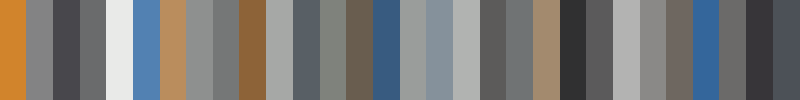

In [76]:
def plot_colors(colors, number_of_occurences, bar_size):
  bar = np.zeros(bar_size, dtype = "uint8")

  right_step_size = bar_size[1] / len(colors)

  x_start = 0
  for color, number_of_occurences in zip(colors, number_of_occurences):
    x_end = x_start + right_step_size
    cv2.rectangle(bar, (int(x_start), 0), (int(x_end), bar_size[0]), color.astype(int).tolist(), -1)
    x_start = x_end

  cv2_imshow(bar)

TOP_N_COLORS = 30
color_names = list(zip(*rgb_occurence_ordered_dict))[0]
number_of_occurences = list(zip(*rgb_occurence_ordered_dict))[1]

color_names = list(reversed(color_names))[:TOP_N_COLORS]
number_of_occurences = list(reversed(number_of_occurences))[:TOP_N_COLORS]

bar_size = (100, 800, 3)

color_names = np.array(color_names)
number_of_occurences = np.array(number_of_occurences)

print("Colors with most occurence: ")
plot_colors(color_names, number_of_occurences, bar_size)